# X5 Retail Hero dataset

In [1]:
from pprint import pprint

import pandas as pd
import matplotlib.pyplot as plt
from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_curve
from sklift.viz import plot_qini_curve
import numpy as np

import warnings
warnings.filterwarnings('ignore')


In [2]:
import statsmodels.api as sm
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression

from causalml.inference.meta import BaseXRegressor, BaseTClassifier, BaseSClassifier
from causalml.dataset import *
from causalml.metrics import *

plt.style.use('fivethirtyeight')

%matplotlib inline

In [3]:
df_clients = pd.read_csv('clients.csv', index_col='client_id')
df_train = pd.read_csv('uplift_train.csv', index_col='client_id')
df_test = pd.read_csv('uplift_test.csv', index_col='client_id')

In [4]:
pd.to_datetime(df_clients['first_issue_date']).min()

Timestamp('2017-04-04 18:24:18')

In [5]:
from sklearn.model_selection import train_test_split

df_features = df_clients.copy()
df_features['first_issue_time'] = \
    (pd.to_datetime(df_features['first_issue_date'])
     - pd.to_datetime(df_features['first_issue_date']).min()) / pd.Timedelta('365d')

df_features['first_redeem_time'] = \
    (pd.to_datetime(df_features['first_redeem_date'])
     - pd.to_datetime(df_features['first_redeem_date']).min()) / pd.Timedelta('365d')

df_features['issue_redeem_delay'] = df_features['first_redeem_time'] \
    - df_features['first_issue_time']

df_features = df_features.join(pd.get_dummies(df_features['gender']))
df_features['first_redeem_time'] = df_features['first_redeem_time'].fillna(df_features['first_redeem_time'].mean())
df_features['issue_redeem_delay'] = df_features['issue_redeem_delay'].fillna(df_features['issue_redeem_delay'].mean())

df_features = df_features.drop(['first_issue_date', 'first_redeem_date', 'gender'], axis=1)

indices_train = df_train.index
indices_test = df_test.index
indices_learn, indices_valid = train_test_split(df_train.index, test_size=0.3, random_state=123)

In [6]:
df_features

,age,first_issue_time,first_redeem_time,issue_redeem_delay,F,M,U
client_id,,,,,,,
000012768d,45,0.336675,0.735365,0.398690,0,0,1
000036f903,72,0.015925,0.033211,0.017286,1,0,0
000048b7a6,68,1.698076,1.208236,0.476130,1,0,0
000073194a,60,0.133622,0.622100,0.488477,1,0,0
00007c7133,67,0.131265,1.724154,1.592889,0,0,1
00007f9014,45,0.383011,1.850413,1.467402,1,0,0
0000a90cf7,45,0.125363,0.241450,0.116087,0,0,1
0000b59cec,46,0.179871,0.713344,0.533473,0,0,1
0000bb4e4e,36,0.095620,0.373441,0.277821,0,1,0


In [7]:
X_train = df_features.loc[indices_learn, :]
y_train = df_train.loc[indices_learn, 'target']
treat_train = df_train.loc[indices_learn, 'treatment_flg']

X_val = df_features.loc[indices_valid, :]
y_val = df_train.loc[indices_valid, 'target']
treat_val =  df_train.loc[indices_valid, 'treatment_flg']

X_train_full = df_features.loc[indices_train, :]
y_train_full = df_train.loc[:, 'target']
treat_train_full = df_train.loc[:, 'treatment_flg']

X_test = df_features.loc[indices_test, :]

cat_features = ['gender']

# ATE

In [9]:
def get_mean_target(treatment_flg):
    return df_train.loc[indices_valid][df_train['treatment_flg']==treatment_flg]['target'].mean()

get_mean_target(1) - get_mean_target(0)

0.0325018461092893

In [41]:
import torch
import random
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
np.random.seed(seed)  # Numpy module.
random.seed(seed)  # Python random module.
torch.manual_seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True


class Data(torch.utils.data.Dataset):
    def __init__(self, X, y):
        super(Data, self).__init__()
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
    
    def __len__(self):
        return self.X.shape[0] # >>> your solution here <<<
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    

class Uplift_NN(torch.nn.Module):
        def __init__(self, input_size, hidden_size):
            super(Uplift_NN, self).__init__()
            self.input_size = input_size
            self.hidden_size  = hidden_size
            self.net = torch.nn.Sequential(
            torch.nn.Linear(input_size, hidden_size, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_size, hidden_size-2, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_size-2, 1, bias=True),
            torch.nn.Sigmoid()
            )
                        
        def forward(self, x):
            output = self.net(x)
            return output
        
        
class Classifier_NN():
    def __init__(self, input_size, hidden_size):
        self.model = Uplift_NN(input_size, hidden_size)
    
    def fit(self,X_train,y_train,epoch = 5, lr = 1e-3):
        self.model.train()
        trainset = Data(X_train,y_train)
        trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,
                                          shuffle=True,num_workers=0)
        optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)
        loss_function = torch.nn.BCEWithLogitsLoss()
        for iter_i in range(epoch):
            for inputs, labels in trainloader:
                optimizer.zero_grad()
                outputs = self.model(inputs)
                loss = loss_function(outputs[:,0], labels)
                loss.backward()
                optimizer.step()
        return self
                
    def predict_proba(self,X_test):
        self.model.eval()
        X_test = torch.from_numpy(X_test.astype(np.float32))
        prob_1 = self.model(X_test)
        prob_0 = torch.ones_like(prob_1)
        prob_0 -= prob_1
        return torch.cat((prob_0, prob_1), 1).detach().numpy()
    
    def predict(self,X_test):
        self.model.eval()
        X_test = torch.from_numpy(X_test.astype(np.float32))
        prob_1 = self.model(X_test)
        out = (prob_1>0.5).float()
        return out

In [42]:
y_pred = (np.random.rand(y_val.shape[0]) >= 0.5).astype(int)
accuracy_score(y_val,y_pred)


# Meta Learners

## T-learner

In [43]:
from econml.metalearners import TLearner


est = TLearner(models = Classifier_NN(X_train.shape[1],4))
est.fit(y_train, treat_train, X_train)
uplift = np.squeeze(est.const_marginal_effect(X_val.values))
score = uplift_at_k(y_true=y_val, uplift=uplift, treatment=treat_val, strategy='by_group', k=0.3)
print(f"econml\t\t| Uplift at 30: {score}")

#causalml
# T Learner
learner_t = BaseTClassifier(learner=Classifier_NN(X_train.shape[1],4))
learner_t.fit(X=X_train, treatment=treat_train, y=y_train)
cate_t = np.squeeze(learner_t.predict(X_val.values))
score = uplift_at_k(y_true=y_val, uplift=cate_t, treatment=treat_val, strategy='by_group', k=0.3)
print(f"causalml\t| Uplift at 30: {score}")

#sklift
from sklift.models import TwoModels
tm = TwoModels(estimator_trmnt=Classifier_NN(X_train.shape[1],4), estimator_ctrl=Classifier_NN(X_train.shape[1],4), method='vanilla')
tm = tm.fit(X_train.values, y_train.values, treat_train.values)
uplift_tm = tm.predict(X_val.values)
score = uplift_at_k(y_true=y_val, uplift=uplift_tm, treatment=treat_val, strategy='by_group', k=0.3)
print(f"sklift\t\t| Uplift at 30: {score}")

econml		| Uplift at 30: 0.03946682679235025
causalml	| Uplift at 30: 0.04593668489481051
sklift		| Uplift at 30: 0.03871844063768293


In [44]:
from sklearn.metrics import accuracy_score
y_pred = (uplift_tm >= 0.5).astype(int)
accuracy_score(y_val,y_pred)

<AxesSubplot:title={'center':'Qini curve\nqini_auc_score=0.0059'}, xlabel='Number targeted', ylabel='Number of incremental outcome'>

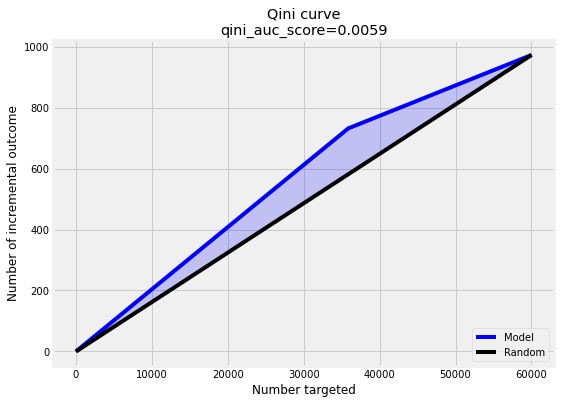

In [46]:
plot_qini_curve(y_true=y_val, uplift=uplift, treatment=treat_val, negative_effect=True, perfect=False)

## S-learner

In [47]:
#econml
from econml.metalearners import SLearner

est = SLearner(overall_model=Classifier_NN(X_train.shape[1]+2,6))
est.fit(y_train, treat_train, X_train)
uplift = np.squeeze(est.const_marginal_effect(X_val.values))
score = uplift_at_k(y_true=y_val, uplift=uplift, treatment=treat_val, strategy='by_group', k=0.3)
print(f"econml\t\t| Uplift at 30: {score}")


#causalml
# S Learner
learner_s = BaseSClassifier(learner=Classifier_NN(X_train.shape[1]+1,5))
learner_s.fit(X=X_train, treatment=treat_train, y=y_train)
cate_s = np.squeeze(learner_s.predict(X_val.values))
score = uplift_at_k(y_true=y_val, uplift=cate_s, treatment=treat_val, strategy='by_group', k=0.3)
print(f"causalml\t| Uplift at 30: {score}")


#sklift
from sklift.models import SoloModel

sm = SoloModel(Classifier_NN(X_train.shape[1]+1,5))
sm = sm.fit(X_train.values, y_train.values, treat_train.values)
uplift_sm = sm.predict(X_val.values)
score = uplift_at_k(y_true=y_val, uplift=uplift_sm, treatment=treat_val, strategy='by_group', k=0.3)
print(f"sklift\t\t| Uplift at 30: {score}")

econml		| Uplift at 30: 0.038945033586110456
causalml	| Uplift at 30: 0.052336047413315656
sklift		| Uplift at 30: 0.04346996888123511


In [48]:
y_pred_1 = (uplift >= 0.5).detach().numpy().astype(int)
y_pred_2 = (cate_s >= 0.5).astype(int)
y_pred_3 = (uplift_sm >= 0.5).astype(int)
accuracy_score(y_val,y_pred_1), accuracy_score(y_val,y_pred_2), accuracy_score(y_val,y_pred_3)

<AxesSubplot:title={'center':'Qini curve\nqini_auc_score=0.0026'}, xlabel='Number targeted', ylabel='Number of incremental outcome'>

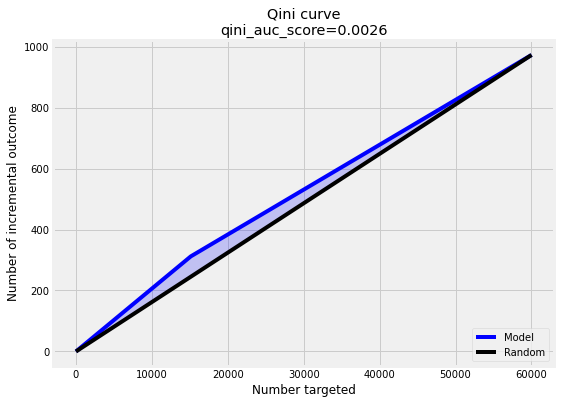

In [49]:
plot_qini_curve(y_true=y_val, uplift=uplift, treatment=treat_val, negative_effect=True, perfect=False)

## X-Learner

In [50]:
#econml
from econml.metalearners import XLearner

est = XLearner(models=Classifier_NN(X_train.shape[1],4))
est.fit(y_train, treat_train, X_train)
uplift = np.squeeze(est.const_marginal_effect(X_val.values))
score = uplift_at_k(y_true=y_val, uplift=uplift, treatment=treat_val, strategy='by_group', k=0.3)
print(f"econml\t\t| Uplift at 30: {score}")

#causalml
# X Learner
learner_x = BaseXRegressor(Classifier_NN(X_train.shape[1],5))
learner_x.fit(X=X_train, treatment=treat_train, y=y_train)
cate_x = np.squeeze(learner_x.predict(X_val.values))
score = uplift_at_k(y_true=y_val, uplift=cate_x, treatment=treat_val, strategy='by_group', k=0.3)
print(f"causalml\t| Uplift at 30: {score}")

MemoryError: Unable to allocate 36.5 GiB for an array with shape (69968, 69968) and data type float64

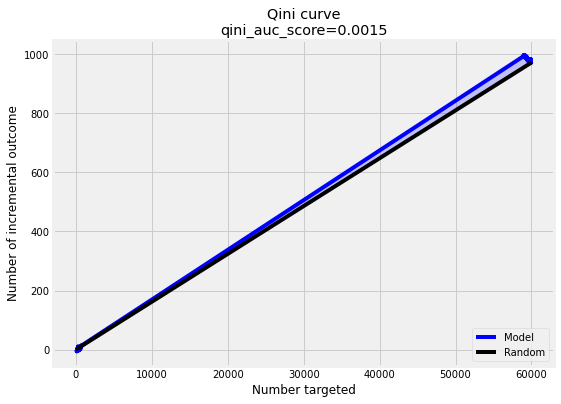

In [53]:
plot_qini_curve(y_true=y_val, uplift=cate_x, treatment=treat_val, perfect=False);